In [1]:
from langchain.prompts import Prompt
from langchain_core.prompts import PromptTemplate

# from function_registry import FunctionRegistry
import os
from langchain_cerebras import ChatCerebras
from dotenv import load_dotenv
# Set up the environment
from langchain.chat_models import init_chat_model

load_dotenv()

llm = ChatCerebras(
    model="llama-3.3-70b",
    api_key=os.getenv("CEREBRAS_API_KEY")
)

In [2]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [3]:
# This is a workaround to get the function signature
from langchain.tools import Tool
from pydantic import BaseModel, Field
from functools import partial


# Tools in LangChain-Format bringen
def make_tool_wrapper(fn_name):
    def _run(*args, **kwargs):
        # Positional Dict -> kwargs
        if args and isinstance(args[0], dict):
            kwargs = args[0]
        return registry.call_function(fn_name, **kwargs)

    return _run


# Generates SQL queries and returns them as a string
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    answer: str = Field(description="The answer to the user's question")
    sql_query: str = Field(description="SQl query to get the answer")

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

query = "Wie gross ist die Fensterfläche im 2. Obergeschoss?"
# agent = create_react_agent(llm=llm, tools=tools, prompt=prompt)
# response = agent.invoke("Wie gross ist die Fensterfläche im 2. Obergeschoss?")

query_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",
         "You are a helpful facility management assistant. Your task is to answer questions about facility management."
         ),
        # Placeholders fill up a **list** of messages
        ("user", "{input}"),
    ]
)
tools = [ResponseFormatter]
# langgraph_agent_executor = create_react_agent(llm, tools, prompt=prompt)
# messages = langgraph_agent_executor.invoke(
#     {"messages": [("user", query)]},
# )
# print(messages["messages"][-1])

model_with_tools = llm.bind_tools(tools, tool_choice='required')
print(model_with_tools.invoke(query))

content='' additional_kwargs={'tool_calls': [{'id': '390b39fb4', 'function': {'arguments': '{"answer": "Die Fensterfl\\u00e4che im 2. Obergeschoss kann nicht ohne weitere Informationen berechnet werden.", "sql_query": "SELECT * FROM Fenster WHERE Etage = 2"}', 'name': 'ResponseFormatter'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 246, 'total_tokens': 292, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'llama-3.3-70b', 'system_fingerprint': 'fp_55092e95d6cc4a5b1785', 'id': 'chatcmpl-f7c6fb0f-d2f3-4a92-96e2-b1005455f775', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run--2285e8cb-f3e3-4590-9580-57ae1ac529c2-0' tool_calls=[{'name': 'ResponseFormatter', 'args': {'answer': 'Die Fensterfläche im 2. Obergeschoss kann nicht ohne weitere Informationen berechnet werden.', 'sql_query': 'SELECT * FROM Fenster WHERE Etage = 

In [5]:
from sqlalchemy import create_engine, inspect
from langchain.sql_database import SQLDatabase

# DB CONNECTION
# SQLAlchemy Engine
engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:5432/{os.getenv('DB_NAME')}")
db = SQLDatabase(engine, schema="public")

In [6]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


# def get_table_info_with_schema(db: SQLDatabase) -> str:
#     """Return fully-qualified table and column info with schema."""
#     tables = db.get_usable_table_names()
#     result = []
#     for table in tables:
#         columns = db.get_table_(table)
#         column_info = ", ".join([f"{c.name} ({c.type})" for c in columns])
#         result.append(f"Table public.{table}: {column_info}")
#     return "\n".join(result)

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "table_names": [f"public.{name}" for name in db.get_usable_table_names()],
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    if result is None or not isinstance(result, dict):
        print("⚠️ LLM failed to produce structured output. Trying raw output.")
        print("Raw LLM Output:\n", result)
        raise ValueError("Structured output failed.")

    return {"query": result["query"]}


write_query({"question": "How many asset_component are there?"})

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

{'query': 'SELECT COUNT(*) FROM asset_component'}

In [7]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}


execute_query({"query": "SELECT COUNT(*) FROM public.asset_component"})

{'result': '[(14021,)]'}

In [8]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}



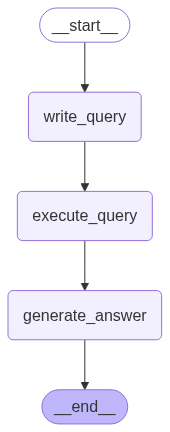

In [9]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
question = "Wie viele Assetkomponenten es gibt? DIE TABELLE heisst asset_component"

for step in graph.stream(
        {"question": question}, stream_mode="updates"
):
    print(step)

C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:338: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this warning may raise an error in a future release.
  metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
C:\Users\Kiril\PycharmProjects\LLM-research\venv\Lib\site-packages\langchain_community\utilities\sql_database.py:350: SAWarning: Cannot correctly sort tables; there are unresolvable cycles between tables "public.contact, public.facility, public.idp_template, public.model, public.project", which is usually caused by mutually dependent foreign key constraints.  Foreign key constraints involving these tables will not be considered; this 

{'write_query': {'query': 'SELECT COUNT(*) FROM asset_component'}}
{'execute_query': {'result': '[(14021,)]'}}
{'generate_answer': {'answer': 'Es gibt 14.021 Assetkomponenten in der Tabelle "asset_component".'}}
